# Data Cleaning

Apple Stocks Dataset: https://www.kaggle.com/datasets/ranugadisansagamage/apple-stocks?resource=download

Donchian Channels Breakout: https://raposa.trade/blog/use-python-to-trade-the-donchian-channel/

Keltner Channels Breakout: https://medium.com/codex/algorithmic-trading-with-the-keltner-channel-in-python-9c272051d43d

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import requests
from math import floor

/Users/rajeshkumar/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
df = pd.read_csv('AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [3]:
df.shape

(10409, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10409 non-null  object 
 1   Open       10409 non-null  float64
 2   High       10409 non-null  float64
 3   Low        10409 non-null  float64
 4   Close      10409 non-null  float64
 5   Adj Close  10409 non-null  float64
 6   Volume     10409 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 569.4+ KB


In [5]:
df.describe().T.apply(lambda x: x.apply("{0:.3f}".format))

,count,mean,std,min,25%,50%,75%,max
Open,10409.000,13.960,30.169,0.050,0.282,0.469,14.218,182.630
High,10409.000,14.112,30.515,0.050,0.288,0.478,14.364,182.940
Low,10409.000,13.809,29.835,0.049,0.275,0.460,14.044,179.120
Close,10409.000,13.967,30.192,0.049,0.281,0.469,14.206,182.010
Adj Close,10409.000,13.350,29.911,0.038,0.235,0.387,12.188,181.778
Volume,10409.000,332177847.171,339334418.573,0.000,124760400.000,219968000.000,412610800.000,7421640800.000


In [6]:
print(df.duplicated().sum())

0


In [7]:
print(df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [8]:
# Handle outliers
q1 = df['Close'].quantile(0.25)
q3 = df['Close'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
df = df[df['Close'] <= upper_bound]

In [9]:
df["Date"] = pd.to_datetime(df["Date"])

In [10]:
df.shape

(9144, 7)

# Exploratory Data Analysis

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

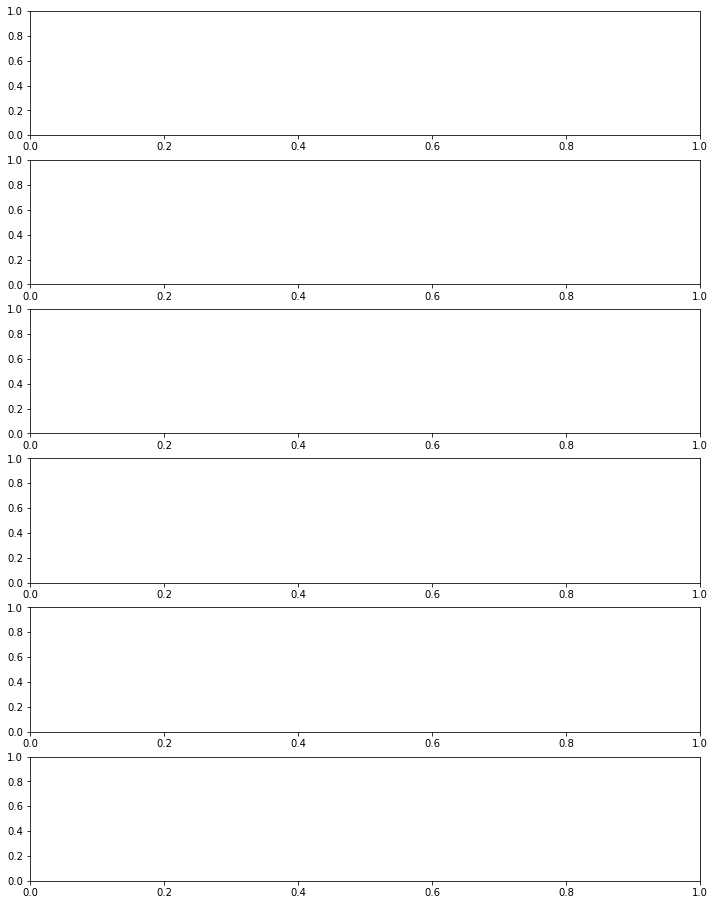

In [11]:
df = df.set_index("Date")
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(12, 16))

# Opening Price
axs[0].plot(df.index, df["Open"])
axs[0].set_title("Opening Price")

# Closing Price
axs[1].plot(df.index, df["Close"])
axs[1].set_title("Closing Price")

# Highest Price
axs[2].plot(df.index, df["High"])
axs[2].set_title("Highest Price")

# Lowest Price
axs[3].plot(df.index, df["Low"])
axs[3].set_title("Lowest Price")

# Adjusted Closing Price
axs[4].plot(df.index, df["Adj Close"])
axs[4].set_title("Adjusted Closing Price")

# Volume
axs[5].plot(df.index, df["Volume"])
axs[5].set_title("Volume")

# Adjust spacing and layout
plt.tight_layout()

# Show the plot
plt.show()

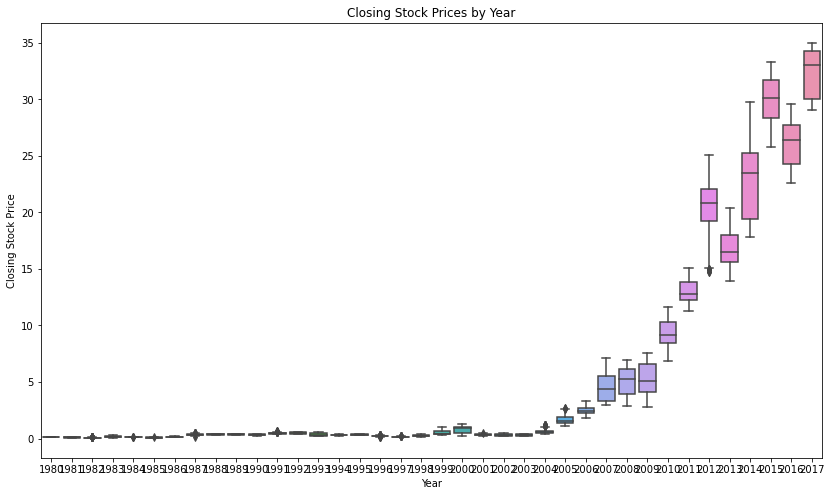

In [12]:
plt.figure(figsize=(14,8))
df['Year'] = df.index.year
sb.boxplot(x='Year', y='Close', data=df)
plt.title('Closing Stock Prices by Year')
plt.xlabel('Year')
plt.ylabel('Closing Stock Price')
plt.show()

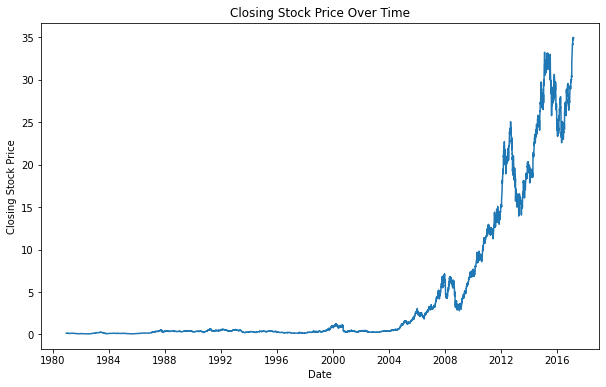

In [13]:
# Line chart of closing stock price over time
plt.figure(figsize=(10, 6))
sb.lineplot(x='Date', y='Close', data=df)
plt.title('Closing Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Stock Price')
plt.show()

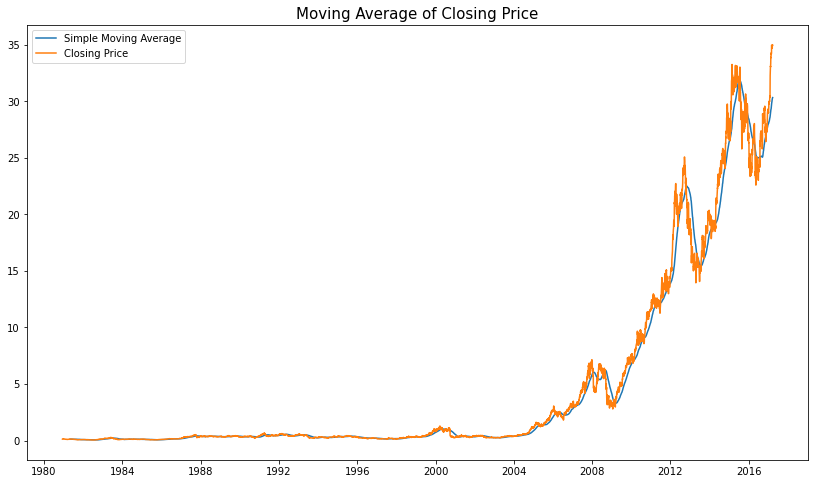

In [14]:
# Calculate the simple moving average
simple_ma = df["Close"].rolling(window=100).mean()

# Create the plot
plt.figure(figsize=(14,8))
plt.plot(simple_ma, label="Simple Moving Average")
plt.plot(df["Close"], label="Closing Price")
plt.xticks(rotation=0)
plt.title("Moving Average of Closing Price", size=15)
plt.legend()
plt.show()

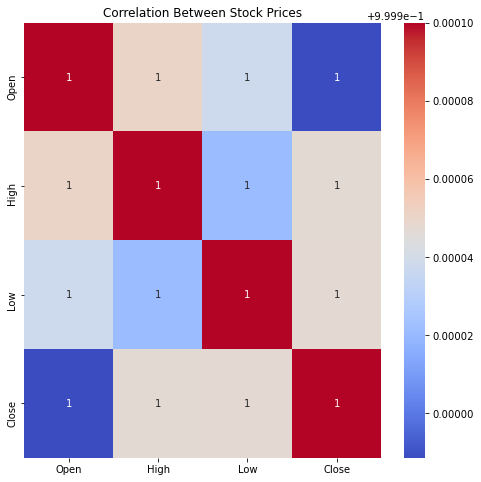

In [15]:
corr = df[['Open', 'High', 'Low', 'Close']].corr()
plt.figure(figsize=(8,8))
sb.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Between Stock Prices')
plt.show()

Opening and closing prices have a strong positive correlation, while the low and high prices have a weaker positive correlation.

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

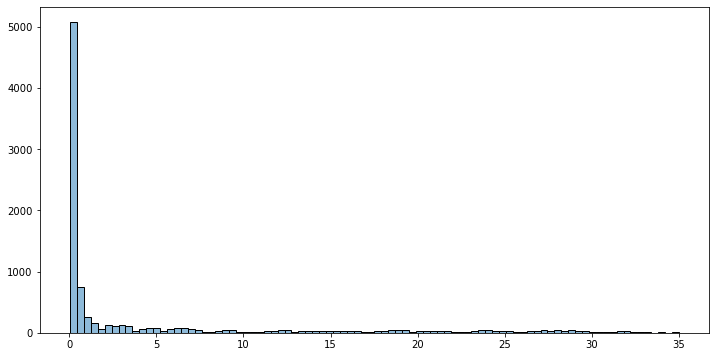

In [16]:
plt.figure(figsize=(12, 6))
sb.histplot(df['Close'], kde=True)
plt.title('Distribution of Closing Stock Price')
plt.xlabel('Closing Stock Price')
plt.ylabel('Frequency')
plt.show()

# Donchian Channels

In [28]:
def calcDonchianChannels(data: pd.DataFrame, period: int):
  data["upperDon"] = data["High"].rolling(period).max()
  data["lowerDon"] = data["Low"].rolling(period).min()
  data["midDon"] = (data["upperDon"] + data["lowerDon"]) / 2
  return data

In [29]:

data = calcDonchianChannels(df, 20)
data.tail()

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,upperDon,lowerDon,midDon
Date,,,,,,,,,,,
2017-03-10,34.812500,34.840000,34.660000,34.785000,32.842602,78451200,0.027500,0.180000,35.070000,33.012501,34.041251
2017-03-13,34.712502,34.857498,34.705002,34.799999,32.856766,69686800,-0.087497,0.152496,35.070000,33.187500,34.128750
2017-03-14,34.825001,34.912498,34.709999,34.747501,32.807194,61236400,0.077500,0.202499,35.070000,33.312500,34.191250
2017-03-17,35.250000,35.250000,34.972500,34.997501,33.043232,175540000,0.252499,0.277500,35.250000,33.654999,34.452500
2017-03-21,35.527500,35.700001,34.932499,34.959999,33.007824,158119600,0.567501,0.767502,35.700001,33.709999,34.705000


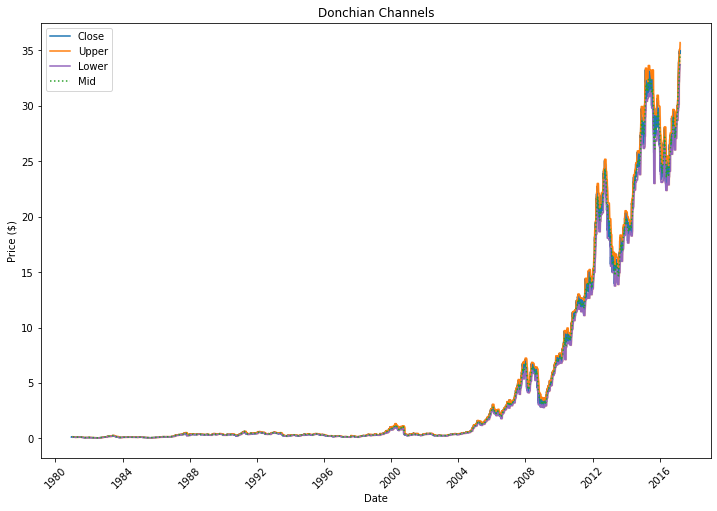

In [30]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.figure(figsize=(12, 8))
plt.plot(data["Close"], label="Close")
plt.plot(data["upperDon"], label="Upper", c=colors[1])
plt.plot(data["lowerDon"], label="Lower", c=colors[4])
plt.plot(data["midDon"], label="Mid", c=colors[2], linestyle=":")
plt.fill_between(data.index, data["upperDon"], data["lowerDon"], alpha=0.3,
                 color=colors[1])

plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.title(f"Donchian Channels")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [31]:
def calcReturns(df):
  df['returns'] = df['Close'] / df['Close'].shift(1)
  df['log_returns'] = np.log(df['returns'])
  df['strat_returns'] = df['position'].shift(1) * df['returns']
  df['strat_log_returns'] = df['position'].shift(1) * \
      df['log_returns']
  df['cum_returns'] = np.exp(df['log_returns'].cumsum()) - 1
  df['strat_cum_returns'] = np.exp(
      df['strat_log_returns'].cumsum()) - 1
  df['peak'] = df['cum_returns'].cummax()
  df['strat_peak'] = df['strat_cum_returns'].cummax()
  return df


In [32]:
def getStratStats(log_returns: pd.Series,
  risk_free_rate: float = 0.02):
  stats = {}  # Total Returns
  stats['tot_returns'] = np.exp(log_returns.sum()) - 1  
  
  # Mean Annual Returns
  stats['annual_returns'] = np.exp(log_returns.mean() * 252) - 1  
  
  # Annual Volatility
  stats['annual_volatility'] = log_returns.std() * np.sqrt(252)
  
  # Sortino Ratio
  annualized_downside = log_returns.loc[log_returns<0].std() * \
    np.sqrt(252)
  stats['sortino_ratio'] = (stats['annual_returns'] - \
    risk_free_rate) / annualized_downside  
  
  # Sharpe Ratio
  stats['sharpe_ratio'] = (stats['annual_returns'] - \
    risk_free_rate) / stats['annual_volatility']  
  
  # Max Drawdown
  cum_returns = log_returns.cumsum() - 1
  peak = cum_returns.cummax()
  drawdown = peak - cum_returns
  max_idx = drawdown.argmax()
  stats['max_drawdown'] = 1 - np.exp(cum_returns[max_idx]) \
    / np.exp(peak[max_idx])
  
  # Max Drawdown Duration
  strat_dd = drawdown[drawdown==0]
  strat_dd_diff = strat_dd.index[1:] - strat_dd.index[:-1]
  strat_dd_days = strat_dd_diff.map(lambda x: x.days).values
  strat_dd_days = np.hstack([strat_dd_days,
    (drawdown.index[-1] - strat_dd.index[-1]).days])
  stats['max_drawdown_duration'] = strat_dd_days.max()
  return {k: np.round(v, 4) if type(v) == np.float_ else v
          for k, v in stats.items()}

In [33]:
def donChannelBreakout(data, period=20, shorts=True):
  data = calcDonchianChannels(data, period)
  
  data["position"] = np.nan
  data["position"] = np.where(data["Close"]>data["upperDon"].shift(1), 1, 
                              data["position"])
  if shorts:
    data["position"] = np.where(
      data["Close"]<data["lowerDon"].shift(1), -1, data["position"])
  else:
    data["position"] = np.where(
      data["Close"]<data["lowerDon"].shift(1), 0, data["position"])
      
  data["position"] = data["position"].ffill().fillna(0)
  
  return calcReturns(data)

In [34]:
breakout = donChannelBreakout(data.copy(), 20, shorts=False)

breakout.tail()

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,upperDon,lowerDon,midDon,position,returns,log_returns,strat_returns,strat_log_returns,cum_returns,strat_cum_returns,peak,strat_peak
Date,,,,,,,,,,,,,,,,,,,,
2017-03-10,34.812500,34.840000,34.660000,34.785000,32.842602,78451200,0.027500,0.180000,35.070000,33.012501,34.041251,1.0,1.003317,0.003312,1.003317,0.003312,270.020974,656.562730,271.287048,709.744064
2017-03-13,34.712502,34.857498,34.705002,34.799999,32.856766,69686800,-0.087497,0.152496,35.070000,33.187500,34.128750,1.0,1.000431,0.000431,1.000431,0.000431,270.137836,656.846266,271.287048,709.744064
2017-03-14,34.825001,34.912498,34.709999,34.747501,32.807194,61236400,0.077500,0.202499,35.070000,33.312500,34.191250,1.0,0.998491,-0.001510,0.998491,-0.001510,269.728808,655.853863,271.287048,709.744064
2017-03-17,35.250000,35.250000,34.972500,34.997501,33.043232,175540000,0.252499,0.277500,35.250000,33.654999,34.452500,1.0,1.007195,0.007169,1.007195,0.007169,271.676637,660.579770,271.676637,709.744064
2017-03-21,35.527500,35.700001,34.932499,34.959999,33.007824,158119600,0.567501,0.767502,35.700001,33.709999,34.705000,1.0,0.998928,-0.001072,0.998928,-0.001072,271.384447,659.870847,271.676637,709.744064


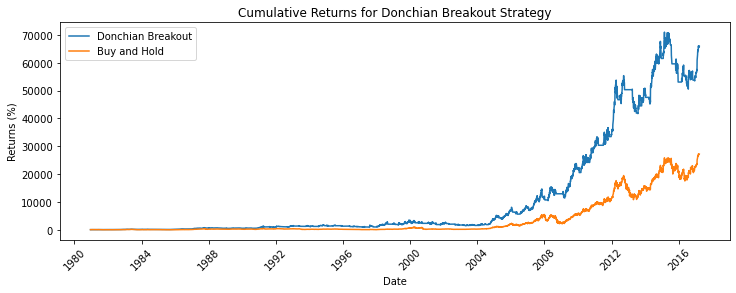

,tot_returns,annual_returns,annual_volatility,sortino_ratio,sharpe_ratio,max_drawdown,max_drawdown_duration
Donchian Breakout,659.8708,0.196,0.3205,0.6297,0.5492,0.5766,1814


In [35]:
breakout = donChannelBreakout(data.copy(), 20, shorts=False)

plt.figure(figsize=(12, 4))
plt.plot( breakout["strat_cum_returns"] * 100, label="Donchian Breakout")
plt.plot(breakout["cum_returns"] * 100, label="Buy and Hold")
plt.title("Cumulative Returns for Donchian Breakout Strategy")
plt.xlabel("Date")
plt.ylabel("Returns (%)")
plt.xticks(rotation=45)
plt.legend()

plt.show()

stats = pd.concat([
                   pd.DataFrame(getStratStats(breakout["strat_log_returns"]),
                               index=["Donchian Breakout"])])
stats

# Keltner Channels

In [36]:
# KELTNER CHANNEL CALCULATION

def get_kc(high, low, close, kc_lookback, multiplier, atr_lookback):
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift()))
    tr3 = pd.DataFrame(abs(low - close.shift()))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(alpha = 1/atr_lookback).mean()
    
    kc_middle = close.ewm(kc_lookback).mean()
    kc_upper = close.ewm(kc_lookback).mean() + multiplier * atr
    kc_lower = close.ewm(kc_lookback).mean() - multiplier * atr
    
    return kc_middle, kc_upper, kc_lower
intc = df
intc['kc_middle'], intc['kc_upper'], intc['kc_lower'] = get_kc(intc['High'], intc['Low'], intc['Close'], 20, 2, 10)
intc.tail(20)

,Open,High,Low,Close,Adj Close,Volume,Open-Close,High-Low,upperDon,lowerDon,midDon,kc_middle,kc_upper,kc_lower
Date,,,,,,,,,,,,,,
2017-02-16,33.917500,33.974998,33.709999,33.837502,31.948011,90338400,0.079998,0.264999,34.067501,29.875000,31.971251,31.043893,31.834592,30.253194
2017-02-17,33.775002,33.957500,33.775002,33.930000,32.035351,88792800,-0.154998,0.182498,34.067501,29.875000,31.971251,31.181327,31.929455,30.433198
2017-02-21,34.057499,34.187500,33.994999,34.174999,32.266663,98028800,-0.117500,0.192501,34.187500,29.875000,32.031250,31.323883,32.048698,30.599067
2017-02-22,34.107498,34.279999,34.027500,34.277500,32.363441,83347600,-0.170002,0.252499,34.279999,30.070000,32.174999,31.464531,32.167365,30.761697
2017-02-23,34.345001,34.369999,34.075001,34.132500,32.226547,83152800,0.212501,0.294998,34.369999,30.155001,32.262500,31.591577,32.283127,30.900027
2017-02-24,33.977501,34.165001,33.820000,34.165001,32.257221,87106400,-0.187500,0.345001,34.369999,30.155001,32.262500,31.714121,32.405516,31.022726
2017-02-27,34.285000,34.360001,34.070000,34.232498,32.320953,81029600,0.052502,0.290001,34.369999,30.155001,32.262500,31.834044,32.514300,31.153788
2017-02-28,34.270000,34.360001,34.174999,34.247501,32.335106,93931600,0.022499,0.185002,34.369999,30.155001,32.262500,31.948970,32.598201,31.299740
2017-03-01,34.472500,35.037498,34.400002,34.947498,32.996021,145658400,-0.474998,0.637496,35.037498,31.752501,33.394999,32.091757,32.834064,31.349450


In [37]:
# KELTNER CHANNEL STRATEGY

def implement_kc_strategy(prices, kc_upper, kc_lower):
    buy_price = []
    sell_price = []
    kc_signal = []
    signal = 0
    
    for i in range(len(prices)):
        if prices[i] < kc_lower[i] and i+1 < len(prices) and prices[i+1] > prices[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        elif prices[i] > kc_upper[i] and i+1 < len(prices) and prices[i+1] < prices[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                kc_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                kc_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            kc_signal.append(0)
            
    return buy_price, sell_price, kc_signal

#intc = intc.tail(20)
#intc = intc.reset_index(drop=True)
#print(intc['Close'])
buy_price, sell_price, kc_signal = implement_kc_strategy(intc['Close'], intc['kc_upper'], intc['kc_lower'])

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

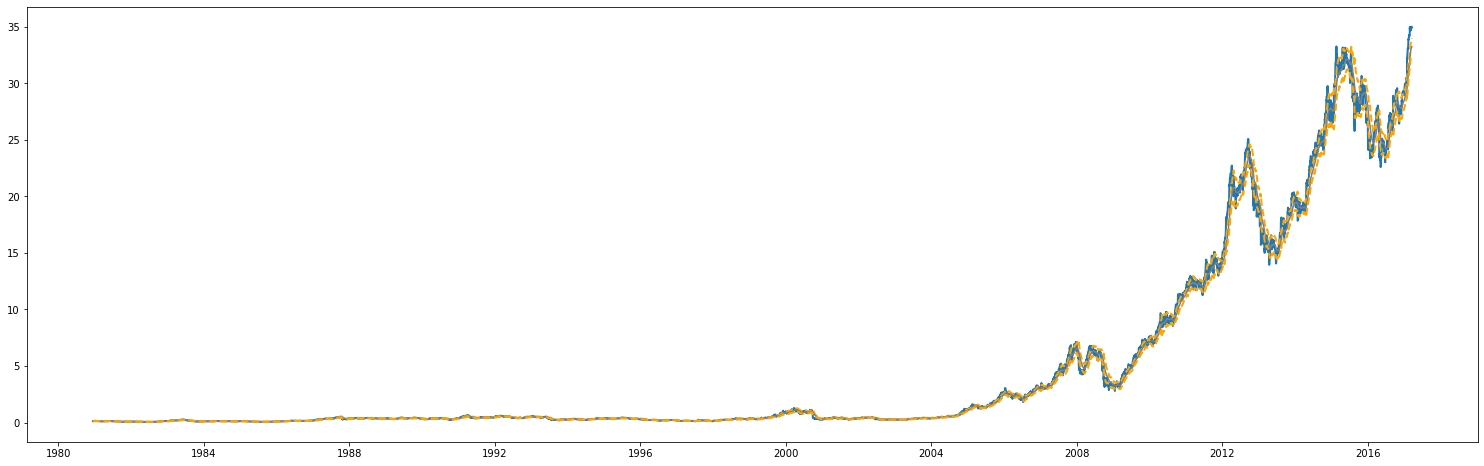

In [38]:
plt.figure(figsize=(26, 8))
plt.plot(intc['Close'], linewidth = 2, label = 'INTC')
plt.plot(intc['kc_upper'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC UPPER 20')
plt.plot(intc['kc_middle'], linewidth = 1.5, color = 'grey', label = 'KC MIDDLE 20')
plt.plot(intc['kc_lower'], linewidth = 2, color = 'orange', linestyle = '--', label = 'KC LOWER 20')
plt.plot(intc.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'BUY SIGNAL')
plt.plot(intc.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'SELL SIGNAL')
plt.legend(loc = 'lower right')
plt.title('INTC KELTNER CHANNEL 20 TRADING SIGNALS')
plt.show()

In [39]:
# STOCK POSITION

position = []
for i in range(len(kc_signal)):
    if kc_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)
        
for i in range(len(intc['Close'])):
    if kc_signal[i] == 1:
        position[i] = 1
    elif kc_signal[i] == -1:
        position[i] = 0
    else:
        position[i] = position[i-1]
        
close_price = intc['Close']
kc_upper = intc['kc_upper']
kc_lower = intc['kc_lower']
kc_signal = pd.DataFrame(kc_signal).rename(columns = {0:'kc_signal'}).set_index(intc.index)
position = pd.DataFrame(position).rename(columns = {0:'kc_position'}).set_index(intc.index)

frames = [close_price, kc_upper, kc_lower, kc_signal, position]
strategy = pd.concat(frames, join = 'inner', axis = 1)

strategy

,Close,kc_upper,kc_lower,kc_signal,kc_position
Date,,,,,
1980-12-12,0.128348,0.129464,0.127232,0,1
1980-12-15,0.121652,0.132495,0.117341,0,1
1980-12-16,0.112723,0.132024,0.109283,0,1
1980-12-17,0.115513,0.129284,0.109261,0,1
1980-12-18,0.118862,0.128657,0.109708,0,1
...,...,...,...,...,...
2017-03-10,34.785000,33.552041,32.196905,0,0
2017-03-13,34.799999,33.606475,32.325854,0,0
2017-03-14,34.747501,33.667770,32.434211,0,0


The value of the position remains 1 if we hold the stock or remains 0 if we sold or don’t own the stock. Should sell when signal is -1. 

In [40]:
# BACKTESTING

intc_ret = pd.DataFrame(np.diff(intc['Close'])).rename(columns = {0:'returns'})
kc_strategy_ret = []

for i in range(len(intc_ret)):
    returns = intc_ret['returns'][i]*strategy['kc_position'][i]
    kc_strategy_ret.append(returns)
    
kc_strategy_ret_df = pd.DataFrame(kc_strategy_ret).rename(columns = {0:'kc_returns'})
investment_value = 100000
number_of_stocks = floor(investment_value/intc['Close'][0])
kc_investment_ret = []

for i in range(len(kc_strategy_ret_df['kc_returns'])):
    returns = number_of_stocks*kc_strategy_ret_df['kc_returns'][i]
    kc_investment_ret.append(returns)

kc_investment_ret_df = pd.DataFrame(kc_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(kc_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print('Profit gained from the KC strategy by investing $100k in INTC : {}'.format(total_investment_ret))
print('Profit percentage of the KC strategy : {}%'.format(profit_percentage))

Profit gained from the KC strategy by investing $100k in INTC : 8770879.46
Profit percentage of the KC strategy : 8770%


In [42]:
# Finding out the percentage of data

outside_upper_band = (intc["Close"] > kc_upper).sum()
outside_lower_band = (intc["Close"] < kc_lower).sum()

total_data_points = len(intc)
percentage_above_upper_band = outside_upper_band / total_data_points * 100
percentage_below_lower_band = outside_lower_band / total_data_points * 100
percentage_total = (outside_upper_band / total_data_points + outside_lower_band / total_data_points) * 100

print(f"Percentage above upper band: {percentage_above_upper_band:.2f}%")
print(f"Percentage below lower band: {percentage_below_lower_band:.2f}%")
print(f"Percentage outside of channels: {percentage_total:.2f}%")

Percentage above upper band: 27.97%
Percentage below lower band: 16.10%
Percentage outside of channels: 44.07%


If there are many data points outside of the Keltner Channels, it could mean that the Keltner Channels may not be as effective in capturing the trading range of the particular stock data. The effectiveness of the Keltner Channels depends on several factors, including the volatility and price movement of the asset.

If an asset has high volatility or experiences frequent price fluctuations, the Keltner Channels may not be as effective in identifying the potential trading range. In this case, a wider range or a different technical analysis tool may be more appropriate. On the other hand, if an asset has low volatility or experiences relatively stable price movement, the Keltner Channels may be more effective in capturing the potential trading range.

It's also important to consider other factors, such as market conditions and fundamental analysis, when assessing the effectiveness of the Keltner Channels. Technical analysis tools like the Keltner Channels should be used in conjunction with other analysis methods to make informed trading decisions.

# K-Nearest Neighbours Classifications

In [43]:
# Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [47]:
df = pd.read_csv('AAPL.csv')
df.head()
print("size of df is " + str(len(df)))

size of df is 10409


In [48]:
# Handle outliers
q1 = df['Close'].quantile(0.25)
q3 = df['Close'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
df = df[df['Close'] <= upper_bound]
print("size of df is " + str(len(df)))

size of df is 9144


In [19]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [49]:
df['Open-Close']= df.Open - df.Close
df['High-Low']  = df.High - df.Low
X= df[['Open-Close', 'High-Low']]
X.head()

,Open-Close,High-Low
0,0.000000,0.000558
1,0.000558,0.000558
2,0.000558,0.000558
3,0.000000,0.000558
4,0.000000,0.000558


In [50]:
Y = np.where(df['Close'].shift(-1)>df['Close'],1,-1)

In [51]:
split_percentage = 0.8
split = int(split_percentage*len(df))

X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [53]:
knn = KNeighborsClassifier(n_neighbors=15)

# fit the model
knn.fit(X_train, Y_train)

# Accuracy Score
accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print ('Train_data Accuracy: %.2f' %accuracy_train)
print ('Test_data Accuracy: %.2f' %accuracy_test)

Train_data Accuracy: 0.60
Test_data Accuracy: 0.51


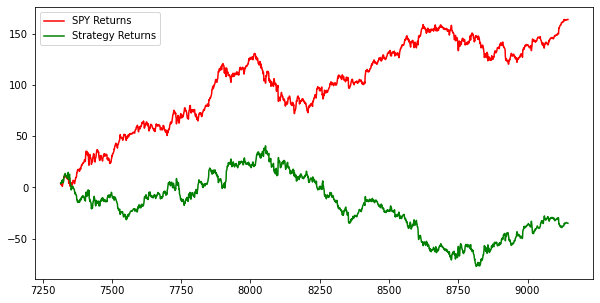

In [54]:
df['Predicted_Signal'] = knn.predict(X)

# SPY Cumulative Returns
df['SPY_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_SPY_returns = df[split:]['SPY_returns'].cumsum()*100

# Cumulative Strategy Returns 
df['Strategy_returns'] = df['SPY_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = df[split:]['Strategy_returns'].cumsum()*100

# Plot the results to visualize the performance

plt.figure(figsize=(10,5))
plt.plot(Cumulative_SPY_returns, color='r',label = 'SPY Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

Our trading strategy is simply to buy or sell. We will predict the signal to buy or sell using ‘predict’ function. Then, we will calculate the cumulative Apple returns for test dataset.

Next, we will calculate the cumulative strategy return based on the signal predicted by the model in the test dataset.

Then, we will plot the cumulative Apple returns and cumulative strategy returns and visualize the performance of the KNN Algorithm.

In [55]:
# Calculate Sharpe ratio
Std = Cumulative_Strategy_returns.std()
Sharpe = (Cumulative_Strategy_returns-Cumulative_SPY_returns)/Std
Sharpe = Sharpe.mean()
print('Sharpe ratio: %.2f'%Sharpe )

Sharpe ratio: -4.33


The Sharpe ratio is the return earned in excess of the market return per unit of volatility. First, we will calculate the standard deviation of the cumulative returns, and use it further to calculate the Sharpe ratio.

# Ridge Regression

In [58]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Define predictors and response
kc = intc['kc_middle']
prices = intc['Close']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(kc.values.reshape(-1, 1), prices, test_size=0.3, random_state=0)

# Fit ridge regression model
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

errors = abs(y_pred - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print('Accuracy:', round(accuracy, 2), '%')
print("R-squared: ", r2)
print('Mean squared error:', mse)
print("Mean absolute error: ", mae)

Accuracy: 90.39 %
R-squared:  0.9965250197381836
Mean squared error: 0.24134259655475548
Mean absolute error:  0.21550846343692626


# Elastic Net Regression

In [59]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Define predictors and response
kc = intc['kc_middle']
prices = intc['Close']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(kc.values.reshape(-1, 1), prices, test_size=0.3, random_state=0)

# Fit elastic net regression model
model = ElasticNet(alpha=0.1, l1_ratio=0.5)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

errors = abs(y_pred - y_test)
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print('Accuracy:', round(accuracy, 2), '%')
print("R-squared: ", r2)
print('Mean squared error:', mse)
print("Mean absolute error: ", mae)

Accuracy: 88.94 %
R-squared:  0.9965122290320951
Mean squared error: 0.24223093029670578
Mean absolute error:  0.21841840028767678


Elastic Net regression is a type of regularized linear regression that combines the L1 and L2 regularization methods. In this context, Elastic Net regression is being used to model the relationship between the Keltner Channels predictor and the stock prices response.

The L1 regularization term encourages the model coefficients to be sparse, meaning it selects a subset of the most important predictors and sets the coefficients of the rest to zero. This helps to avoid overfitting and improve model interpretability. The L2 regularization term, on the other hand, shrinks the coefficients of the remaining predictors towards zero, which helps to improve the stability and generalization of the model.

By combining these two regularization methods, Elastic Net regression is able to handle situations where there are a large number of predictors, some of which may be correlated with each other. It also allows us to control the balance between the L1 and L2 regularization terms using the l1_ratio parameter.



# Random Forest Regression

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Prepare the data
X = intc["kc_middle"].values.reshape(-1, 1) # Predictor variable
y = intc["Close"].values # Response variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = model.predict(X_test)

errors = abs(y_pred - y_test)

# Evaluate the model's performance
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)

print('Accuracy:', round(accuracy, 2), '%')
print("R-squared: {:.2f}".format(r2))
print("Mean squared error: {:.2f}".format(mse))
print("Mean absolute error: {:.2f}".format(mae))

Accuracy: 90.8 %
R-squared: 0.99
Mean squared error: 0.49
Mean absolute error: 0.27


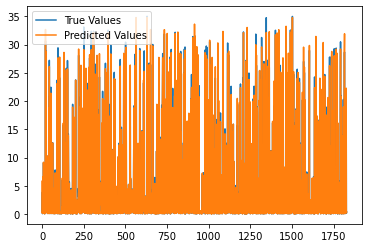

In [57]:
plt.plot(y_test, label="True Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.show()